/tmp/ipython-input-1153869896.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", start="2020-01-01", end="2026-01-01") # Extend end date to 2026
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open       Volume
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD      BTC-USD
Date                                                                       
2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  18565664997
2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  20802083465
2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  28111481032
2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  18444271275
2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  19725074095
Training model...
Epoch 1/20



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0370
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0031
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0024
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0022
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0022
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0020
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0019
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0020
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0017
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0020
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0017
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0017
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0015
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0014
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0014
Epoch 16/20
63/

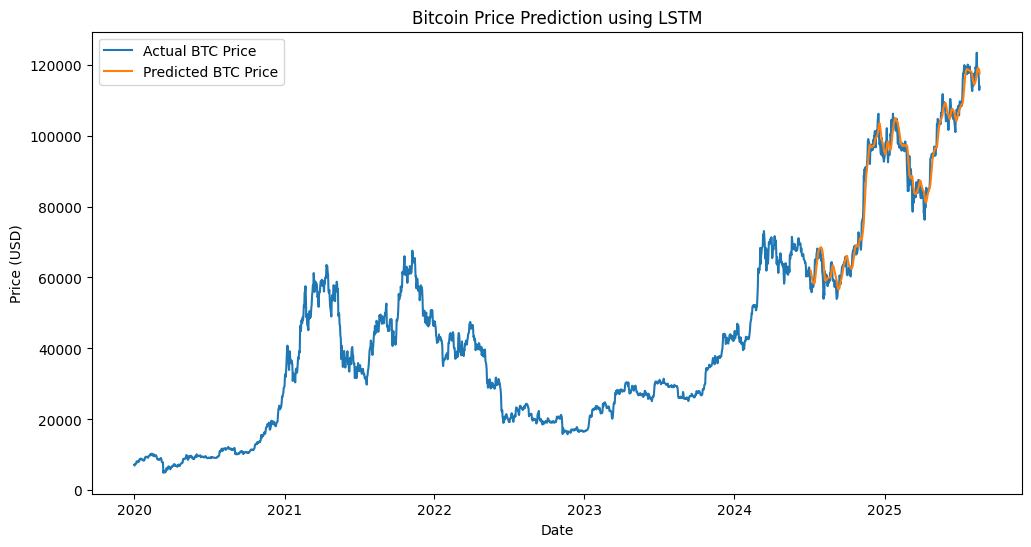

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

print("Downloading Bitcoin data...")
df = yf.download("BTC-USD", start="2020-01-01", end="2026-01-01") # Extend end date to 2026

print(df.head())

data = df[['Close']].values


scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

sequence_length = 60

x_train, y_train = [], []
for i in range(sequence_length, len(scaled_data)):
    x_train.append(scaled_data[i-sequence_length:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predict next closing price

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


print("Training model...")
history = model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1)


train_size = int(len(scaled_data) * 0.8)
test_data = scaled_data[train_size - sequence_length:]

x_test = []

for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


plt.figure(figsize=(12,6))
plt.plot(df.index, data, label="Actual BTC Price") # Use df.index for x-axis
# Plot predictions against the corresponding dates in the test set
plt.plot(df.index[train_size:train_size+len(predictions)], predictions, label="Predicted BTC Price")
plt.xlabel("Date") # Change label to Date
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Prediction using LSTM")
plt.legend()
plt.show()